In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

CHEN_DATA_DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
CHEN_FILE_STEM = f'Supplementary_Data_2' # chen scores for 1kb windows

import pandas as pd
import numpy as np 

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

plt.rcParams['font.size'] = 16

In [2]:
def get_gnocchi_and_GC_content(window_size): 
  filename = f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}.GC_content_{window_size}.bed'  
  df = pd.read_csv(
    filename, 
    sep='\t',
  )
  return df 

get_gnocchi_and_GC_content(window_size=1000000)

,window_chrom,window_start,window_end,chen_chrom,chen_start,chen_end,chen_score,window_GC_content
0,chr1,283499,1283500,chr1,783000,784000,1.355101,0.458393
1,chr1,284499,1284500,chr1,784000,785000,1.745145,0.458646
2,chr1,286499,1286500,chr1,786000,787000,4.388539,0.459216
3,chr1,287499,1287500,chr1,787000,788000,1.893217,0.459528
4,chr1,292499,1292500,chr1,792000,793000,2.075487,0.461101
...,...,...,...,...,...,...,...,...
1984895,chr9,137638499,138394717,chr9,138138000,138139000,3.777362,0.442944
1984896,chr9,137639499,138394717,chr9,138139000,138140000,4.693755,0.443032
1984897,chr9,137658499,138394717,chr9,138158000,138159000,1.646564,0.442308
1984898,chr9,137710499,138394717,chr9,138210000,138211000,2.748850,0.439791


## Spot-checking the specificity of the corrected z-score 

chr1:183400000-201000000


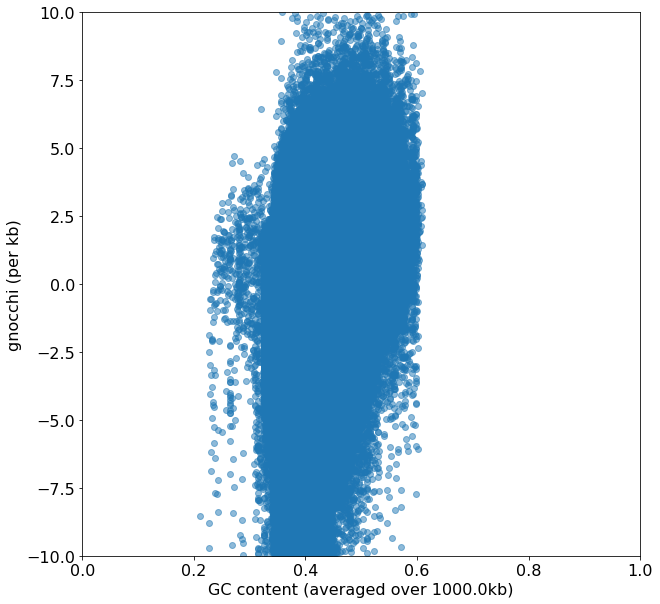

<ipython-input-10-8a2c1790215d>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chen_center'] = (df['chen_start'] + df['chen_end'])/2


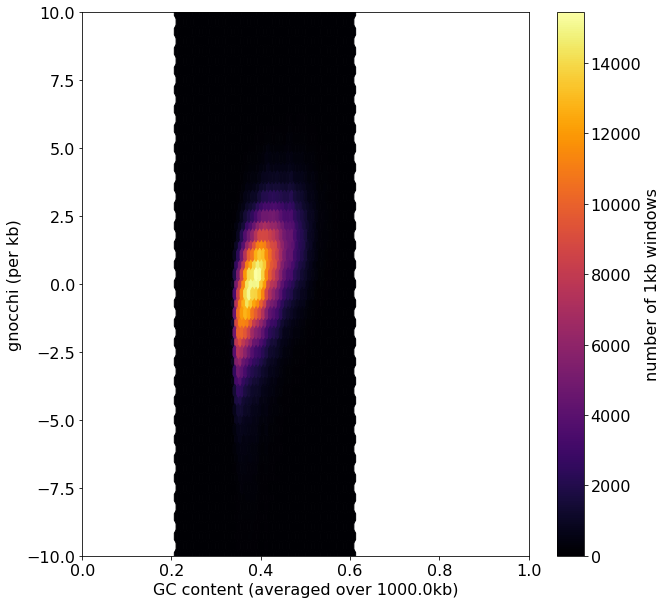

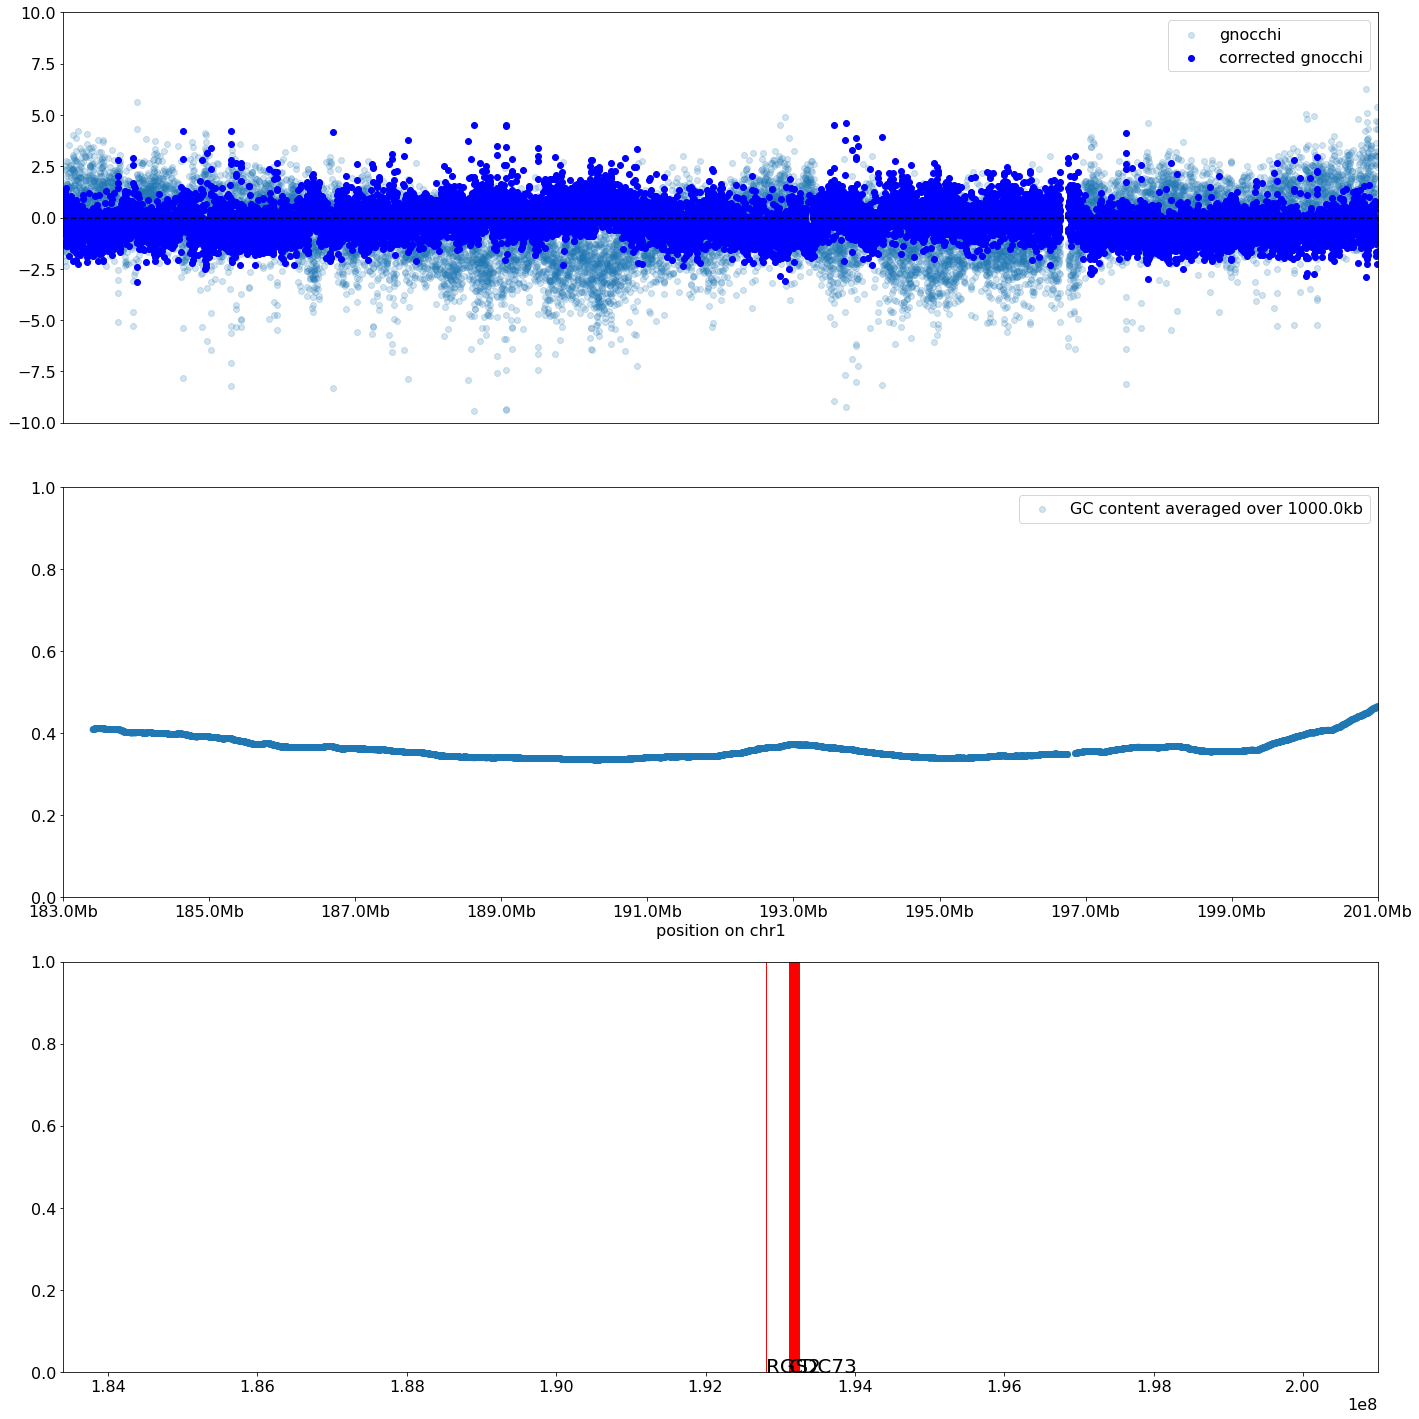

In [10]:
# TODO 

# 1. is corrected gnocchi more specific to *critical* genes than uncorrected gnocchi?
# 2. plot corrected gnocchi in UCSC browser, and show that corrected zscore is more specific to any gene than the original z-score, similar to how spliceAI is more specific to splice sites than CADD

import matplotlib.patches as patches

# https://www.nxn.se/valent/visualizing-overlapping-intervals
def intervals2layers(intervals):
  sorted_intervals = sorted(intervals, key=lambda interval: interval[0])
  layers = [[sorted_intervals[0]]]
  for interval in sorted_intervals[1:]:
    # else clause on a loop: 
    # https://docs.python.org/3/tutorial/controlflow.html#break-and-continue-statements-and-else-clauses-on-loops
    for layer in layers:  
      if layer[-1][1] < interval[0]: # no overlap
        layer.append(interval)
        break
    else:
      layers.append([interval])
  return layers

def plot_gene_pileup(ax, df):
  intervals = df[['gene_start', 'gene_end', 'gene_symbol']].to_records(index=False).tolist()
  layers = intervals2layers(intervals)

  for i, layer in enumerate(layers):
    gene_starts, gene_ends, gene_symbols = zip(*layer)
    for gene_start, gene_end, gene_symbol in zip(gene_starts, gene_ends, gene_symbols):
      rect = patches.Rectangle(
        xy=(gene_start, i), 
        width=gene_end-gene_start, 
        height=1, 
        linewidth=1, 
        edgecolor='r', 
        facecolor='r'
      )
      ax.add_patch(rect)
      ax.text(gene_start, i, gene_symbol, fontsize=20)

def plot_critical_genes(ax, chromosome, start, end): 
  df = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/critical.genes.sorted.bed', 
    sep='\t', 
    header=None,
    names=['gene_chrom', 'gene_start', 'gene_end', 'gene_symbol']
  )

  df = df[df['gene_chrom'] == chromosome] 
  df = df[(df['gene_start'] > start) & (df['gene_end'] < end)]

  plot_gene_pileup(ax, df)

def correct_gnocchi(df, window_size):
  GC = np.array(df['window_GC_content'])
  gnocchi = np.array(df['chen_score'])

  plt.figure(figsize=(10, 10))
  plt.scatter(GC, gnocchi, alpha=0.5)
  plt.xlabel(f'GC content (averaged over {window_size/1000}kb)')
  plt.ylabel('gnocchi (per kb)')
  plt.xlim(0, 1)
  plt.ylim(-10, 10)
  plt.show()

  plt.figure(figsize=(10, 10))
  hb = plt.hexbin(GC, gnocchi, gridsize=50, cmap='inferno')
  cb = plt.colorbar(hb)
  cb.set_label('number of 1kb windows')
  plt.xlabel(f'GC content (averaged over {window_size/1000}kb)')
  plt.ylabel('gnocchi (per kb)')
  plt.xlim(0, 1)
  plt.ylim(-10, 10)

  X = GC.reshape(-1, 1)
  y = gnocchi

  model_mean = LinearRegression()
  model_mean.fit(X, y)
  predicted_mean = model_mean.predict(X)

  residuals = y - predicted_mean

  # Predict the variance using the squared residuals
  model_variance = LinearRegression()
  model_variance.fit(X, residuals**2)
  predicted_variance = model_variance.predict(X)

  df['corrected_chen_score'] = (predicted_mean - y) / np.sqrt(predicted_variance)

  return df

def round_to_nearest_million(x):
  multiple = x / 1e6
  multiple = round(multiple)
  return int(multiple * 1e6)

def plot_gnocchi(df, chromosome, start, end, window_size, tick_interval=2e6):
  df = df[df['window_chrom'] == chromosome] 

  df['chen_center'] = (df['chen_start'] + df['chen_end'])/2
  df = df[
    (df['chen_center'] > start) &
    (df['chen_center'] < end)
  ]

  x = np.array(df['chen_center'])
  y = np.array(df['chen_score'])
  y_corrected = np.array(df['corrected_chen_score'])
  GC = np.array(df['window_GC_content'])

  fig, axs = plt.subplots(3, figsize=(20, 20))

  axs[0].scatter(x, y, label='gnocchi', alpha=0.2)
  axs[0].scatter(x, y_corrected, color='blue', label='corrected gnocchi')
  axs[0].set_xlim(start, end)
  axs[0].set_ylim(-10, 10)
  axs[0].set_xticks([])
  axs[0].legend()

  axs[1].scatter(x, GC, label=f'GC content averaged over {window_size/1000}kb', alpha=0.2)
  axs[1].set_xlabel(f'position on {chromosome}')
  axs[1].set_xlim(start, end)
  axs[1].set_ylim(0, 1)
  axs[1].legend()

  smallest_tick = round_to_nearest_million(min(x)) 
  largest_tick = round_to_nearest_million(max(x))
  xticks = np.arange(smallest_tick, largest_tick+1, tick_interval)
  axs[1].set_xticks(xticks)

  formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1e6}Mb')
  axs[1].xaxis.set_major_formatter(formatter)

  axs[0].plot([start, end], [0, 0], color='black', linestyle='--')

  plot_critical_genes(axs[2], chromosome, start, end)
  axs[2].set_xlim(start, end)

  plt.tight_layout()
  plt.show()

def correct_and_plot_gnocchi(chromosome, start, end, window_size, tick_interval=2e6):
  print(f'{chromosome}:{start}-{end}') 
  
  df = get_gnocchi_and_GC_content(window_size)

  df = correct_gnocchi(df, window_size)

  plot_gnocchi(df, chromosome, start, end, window_size, tick_interval)

correct_and_plot_gnocchi(chromosome='chr1', start=183400000, end=201000000, window_size=1000000)

chr2:4000000-15000000


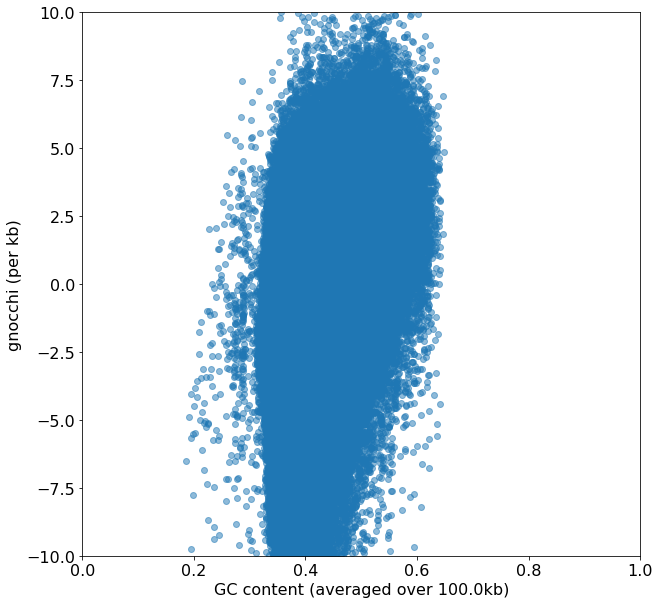

<ipython-input-10-8a2c1790215d>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chen_center'] = (df['chen_start'] + df['chen_end'])/2


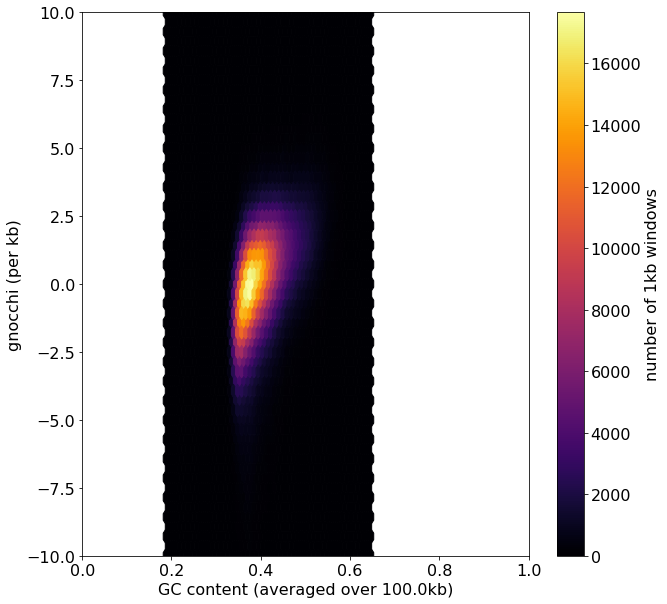

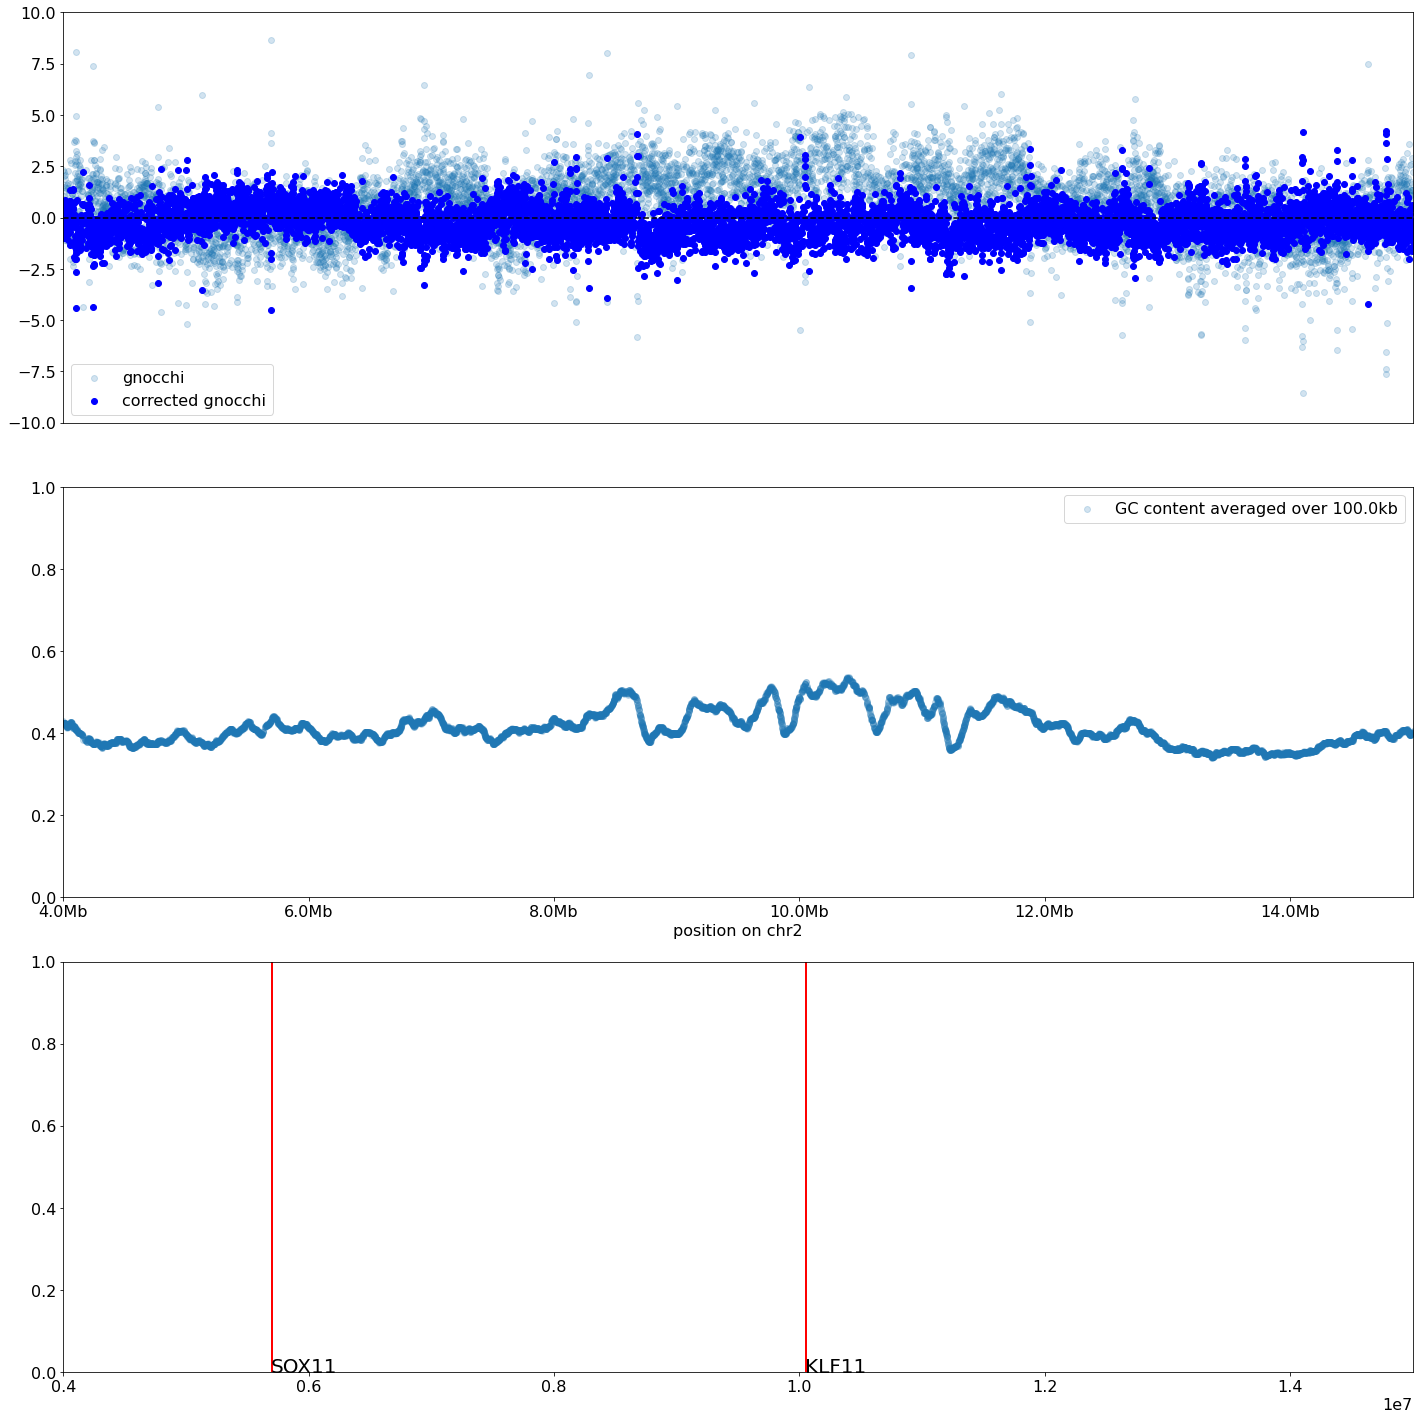

In [12]:
correct_and_plot_gnocchi(chromosome='chr2', start=4000000, end=15000000, window_size=100000)

## z-score does depend on GC content at small length scales, as expected since z-score depends on gene presence, and that correlates with GC content.


In [5]:
# TODO: create plots for this 

## z-score depends on GC content evaluated at large length scales, which is worrying...

In [6]:
# TODO: create plots for this 

## Validation: do this for various GC-window sizes to empirically determine the best window size for z-score calibration.

In [7]:
# TODO 

# 0. review presentations to see what other validation metrics I've used in the past 

# 2. does corrected gnocchi better separate the coding and noncoding score distributions than the original gnocchi?
# 3. does corrected gnocchi better separate the constrained and unconstrained enhancers than the original gnocchi? experiments/germline-model/chen-et-al-2022/SNV_plus_SV_model.4.ipynb

# 0. compute an expected SNV count using corrected z-scores, and compare to observed SNV count (scatter plot), and demonstrate that R2 is higher than using original z-scores
# 1. create a UCSC track for the expected SNV count using corrected z-scores, and compare to observed SNV count, just like Mural did for their model 
# 1. do QQ-plots for the corrected gnocchi scores look better than the original?
# 2. is ROC for noncoding pathogenic variants better using corrected gnocchi scores, vs original gnocchi scores?
